# Positional Encoding Exploration 

We explore the following:
1. Visualization of absolute sinusoidal positional encodings, investigate offsets and understand why it works. Visualize dot products.
2. Implementation and visualization of RoPE embeddings.
3. Learned absolute positional encodings. Download from GPT-2, visualize dot products.

In [2]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import Optional
from transformers import GPT2Model

%matplotlib inline

## Absolute Sinusoidal Positional Encodings and Viz Tools

These encodings are of the form $\Pi \in \mathbb{R}^{N, D}$ where `N` is max token length, `D` is token dimension.

They are computed as:
$$\Pi_{n, d} = \begin{cases} \sin\left(\frac{n}{10000^\frac{d}{D}}\right) & d \text{ even} \\ \cos\left(\frac{n}{10000^\frac{d}{D}}\right) & d \text{ odd} \end{cases}$$

1. We first visualize the sinusoids across positions. `N = 1024`, `D = 768`. We do this for selected `D` (even and odd) to get an idea.
2. We write a util fn to take in absolute positional encoding matrix and visualize the attention score heatmap in a `N x N` grid. This will give us intuition on the dot products.

In [3]:
def compute_absolute_encodings(
    num_positions: int,
    d_model: int,
) -> torch.Tensor:
    """
    Compute absolute positional encodings.
    :param num_positions: Number of positions.
    :param d_model: Dimension of the model.
    :return: Absolute positional encodings.
    """
    position = torch.arange(num_positions).unsqueeze(1)  # (num_positions, 1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))  # (d_model/2,)
    pe = torch.zeros(num_positions, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)  # evens
    pe[:, 1::2] = torch.cos(position * div_term)  # odds
    return pe

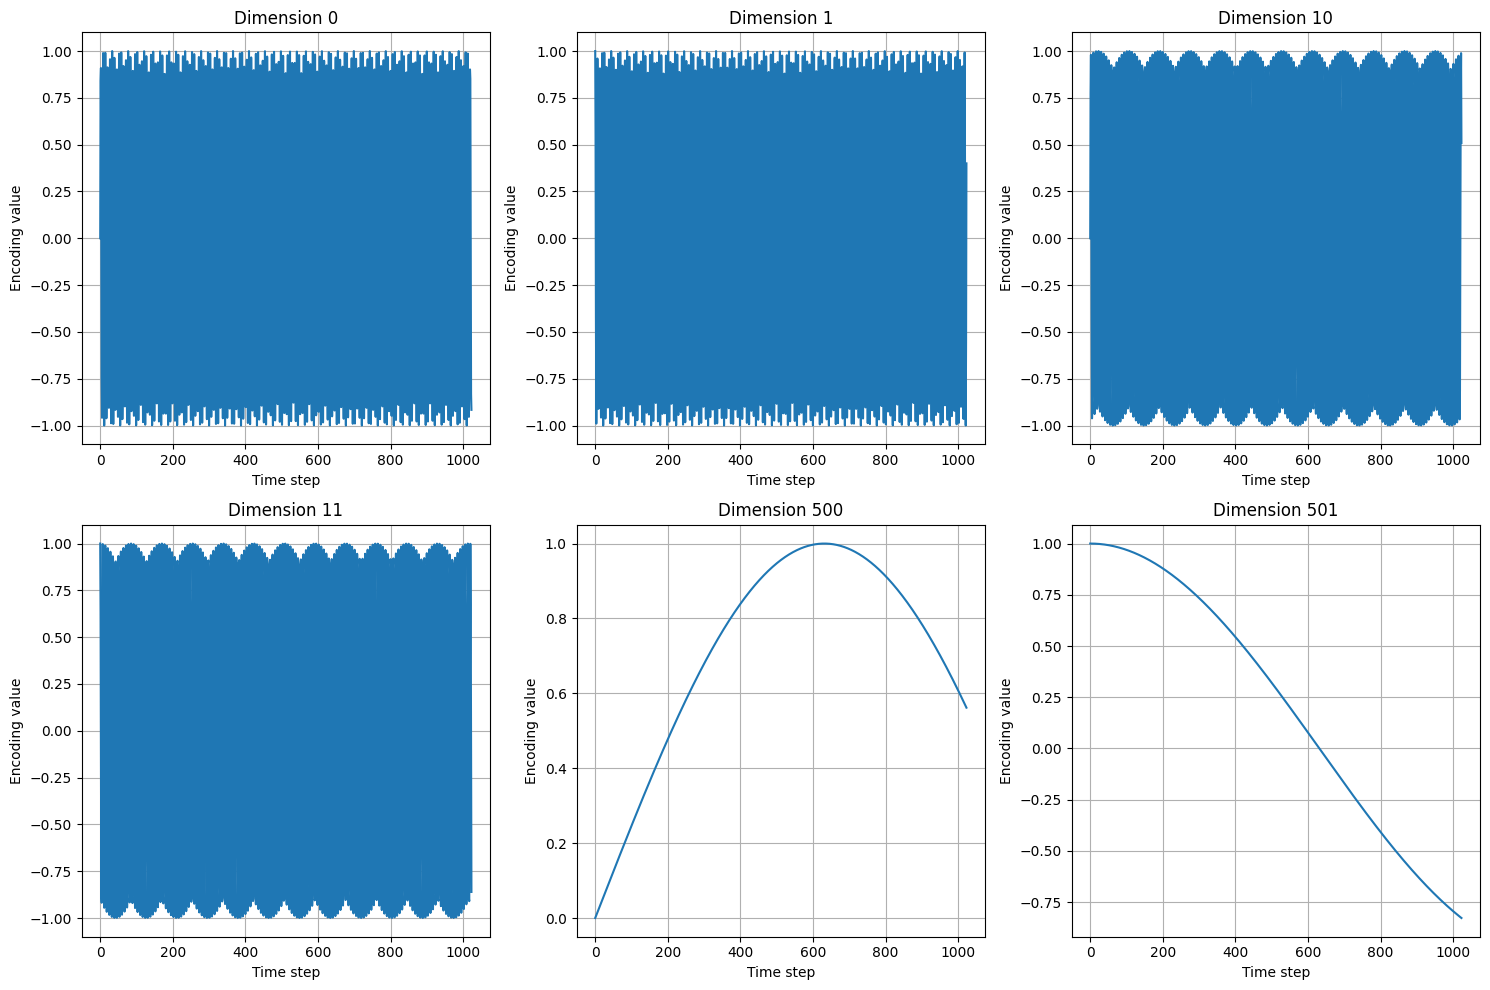

In [4]:
pos_enc = compute_absolute_encodings(1024, 768)

# plot encoding vs time step for each dimension in a grid
dimensions_to_plot = [0, 1, 10, 11, 500, 501]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, dim in enumerate(dimensions_to_plot):
    ax = axes.flatten()[i]
    ax.plot(pos_enc[:, dim].numpy())
    ax.set_title(f"Dimension {dim}")
    ax.set_xlabel("Time step")
    ax.set_ylabel("Encoding value")
    ax.grid()
plt.tight_layout()
plt.show()

In [5]:
def visualize_dot_products(encodings: torch.Tensor, max_n: Optional[int] = None) -> None:
    """
    Visualize the dot products of the encodings.
    :param encodings: Positional encodings.
    """
    if max_n is not None:
        encodings = encodings[:max_n, :]
    dot_products = torch.matmul(encodings, encodings.T)
    plt.imshow(dot_products.numpy(), cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title("Dot Products of Positional Encodings")
    plt.xlabel("Token Index")
    plt.ylabel("Token Index")
    plt.show()

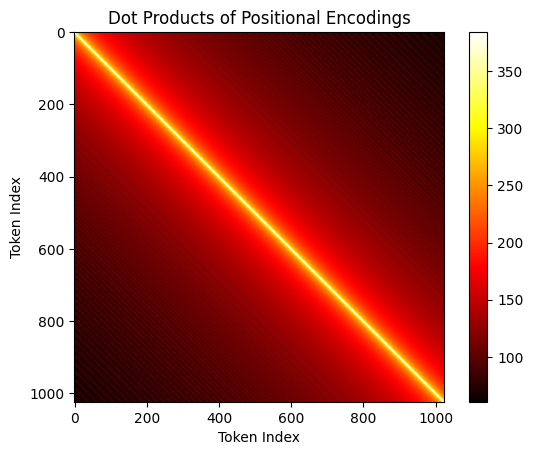

In [6]:
visualize_dot_products(pos_enc)

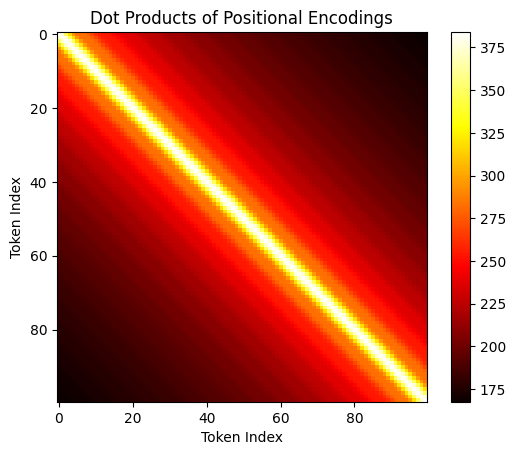

In [7]:
visualize_dot_products(pos_enc, max_n=100)

## Visualize Learned Absolute Positional Encoding
Here we look into GPT-2's absolute positional encoding and understand how the dot products look visualized.

In [8]:
model = GPT2Model.from_pretrained('gpt2')
gpt2_encodings = model.wpe.weight

In [9]:
gpt2_encodings.shape

torch.Size([1024, 768])

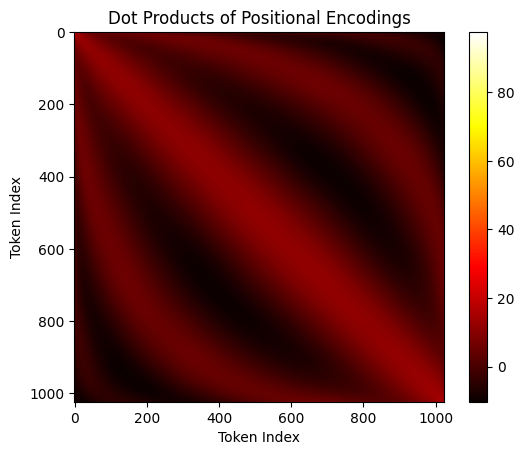

In [10]:
gpt2_encodings = gpt2_encodings.detach()
visualize_dot_products(gpt2_encodings)

Weird looking - we have strong dot products along the diagonal, but random patterns on offsets e.g. 700 and 200. Why do we get higher dot product values there again?

Symmetric about i = j axis. 

## RoPE Embeddings
We'll generate static `q`, `k` matrices of shape `N x D`. 

Then, we'll implement RoPE for this by blockwise rotations of `q` and `k`. Then visualize the dot products. The influence should be more attention for smaller `|i - j|` deltas.

In [11]:
# generate random q, k
queries = torch.ones(1024, 768)
keys = torch.ones(1024, 768)

# normalize
queries = queries / queries.norm(dim=-1, keepdim=True)
keys = keys / keys.norm(dim=-1, keepdim=True)

# compute positionless dot products
dot_products = queries @ keys.T

In [12]:
def rope(input: torch.Tensor) -> torch.Tensor:
    # apply blockwise rotations on queries and keys

    seq_len, dim = input.shape

    # 1. Precompute frequencies
    position = torch.arange(seq_len).unsqueeze(1)  # (N, 1)
    dim_pair = torch.arange(0, dim, 2).float()  # (D//2,)
    freqs = 1.0 / (10000 ** (dim_pair / dim))  # (D//2,)
    
    # 2. Compute angles (broadcast multiplication)
    angles = position * freqs  # (N, D//2)
    
    # 3. Prepare rotation matrices
    cos = torch.cos(angles)
    sin = torch.sin(angles)
    
    # 4. Reshape input into pairs
    input_reshaped = input.view(seq_len, dim//2, 2)  # (N, D//2, 2)
    
    # 5. Apply rotation using vectorized operations
    rotated = torch.stack([
        input_reshaped[..., 0] * cos - input_reshaped[..., 1] * sin,
        input_reshaped[..., 0] * sin + input_reshaped[..., 1] * cos
    ], dim=-1)  # (N, D//2, 2)
    
    return rotated.view(seq_len, dim)

In [13]:
rotated_queries = rope(queries)
rotated_keys = rope(keys)

In [14]:
rotated_dot_products = rotated_queries @ rotated_keys.T

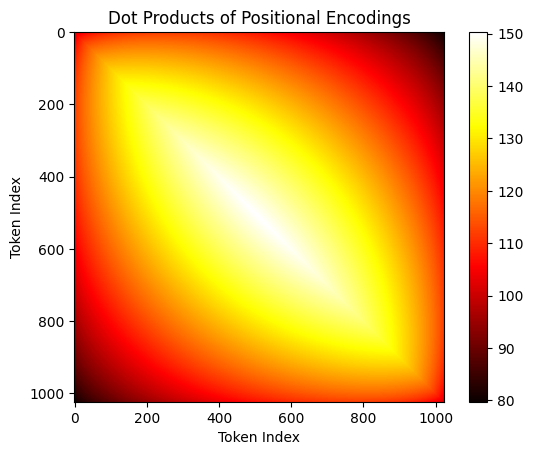

In [15]:
visualize_dot_products(rotated_dot_products)